In [1]:
#imports
import numpy as np
from ct_support_code import *

# **Q1**

## Q1 a

In [2]:

data = np.load('data/ct_data.npz')
X_train = data['X_train']; X_val = data['X_val']; X_test = data['X_test']
y_train = data['y_train']; y_val = data['y_val']; y_test = data['y_test']

In [3]:
def get_mean_and_std_err(data):
    std_err = np.std(data, ddof=1) / np.sqrt(np.size(data)) #used unbiased estimaror for std dev.
    return np.mean(data), std_err

y_val_mu, y_val_std_err = get_mean_and_std_err(y_val)
print("Mean of y_val: ", y_val_mu, "with standard error: ", y_val_std_err)

y_train_mu_slice, y_train_std_err_slice = get_mean_and_std_err(y_train[:5785])
print("Mean of first 5,785 entries of y_train: ", y_train_mu_slice,
    "with standard error: ", y_train_std_err_slice)

Mean of y_val:  -0.2160085093241599 with standard error:  0.01290449880016868
Mean of first 5,785 entries of y_train:  -0.44247687859693674 with standard error:  0.011927303389170828


In [4]:
#NOT ASKED FOR
y_train_mu , y_train_std_err = get_mean_and_std_err(y_train)
print("Mean of y_train: ",  y_train_mu, "with standard error: ", y_train_std_err)

Mean of y_train:  -9.13868774539957e-15 with standard error:  0.0049535309340638205


## Q1 b

In [5]:
all_cols = range(X_train.shape[1])   # Get all col indices.

# Get redundant columns with const vals.
const_col_ind = []
for col_index in all_cols:
    if np.std(X_train[:,col_index]) == 0:
        const_col_ind.append(col_index)

print("Indices of constant redundant columns: ", const_col_ind)

# Get redundant repeated columns.
un_arr, un_ind = np.unique(X_train, return_index=True, axis=1)
# Repeated col indices are all except those with constant values and those that are unique.
repeated_col_ind = sorted(set(all_cols) - set(const_col_ind) - set(un_ind))

print("Indices of subsequent repeated columns after first appearance: ", repeated_col_ind)

# Remove all that are either repeated or unique.
all_cols_to_rmv = list(set(repeated_col_ind) | set(const_col_ind))

# Finally process all three arrays to remove redundant features:
X_train = np.delete(X_train, all_cols_to_rmv, axis=1)
X_val = np.delete(X_val, all_cols_to_rmv, axis=1)
X_test = np.delete(X_test, all_cols_to_rmv, axis=1)

Indices of constant redundant columns:  [59, 69, 179, 189, 351]
Indices of subsequent repeated columns after first appearance:  [78, 79, 188, 199, 287, 359]


# **Q2**

In [6]:
from ct_support_code import *

def fit_linreg(X, yy, k):
    """Fit linear regression problem using least squares. Return mimicks ct_suppor_code´s
    
    I.e return feature weights (Kx1), bias term, and RMSE."""
    N, K = X.shape

    # Modify so lstsq can incorporate regularisation. (Careful not to regularise b).
    yy_tilde = np.vstack([yy[:,None], np.zeros((K,1))]) #(N+K) x 1 vector.
    X_tilde = np.vstack([X, np.sqrt(alpha)*np.eye(K)])

    # Modify design matrix to allow lstsq to also fit bias (constant) term b.
    # Will require 1s before original X, and 0s before regularisation diag matrix.
    prepend_bias = np.concatenate((np.ones(N),np.zeros(K)))
    X_tilde_bias = np.hstack([prepend_bias[:,None], X_tilde])   # (N+K) x (K+1) matrix.

    # lstsq(a,b) solves a@x=b. I.e Xw = yy in our case to find optimized weights.
    ww_fit, _, _, _ = np.linalg.lstsq(X_tilde_bias, yy_tilde, rcond=None) # K+1 weights for K BFs plus constant term.
    return ww_fit[1:], ww_fit[0]

ww_lstsq, bb_lstsq = fit_linreg(X_train, y_train, alpha=30)
ww_gradopt, bb_gradopt= fit_linreg_gradopt(X_train, y_train, alpha=30)

pred_lstsq_train = X_train@ww_lstsq + bb_lstsq     # yy predictions from Xw = yy for our fitted w.
pred_lstsq_val = X_val@ww_lstsq + bb_lstsq
pred_gradopt_train = X_train@ww_gradopt + bb_gradopt
pred_gradopt_val = X_val@ww_gradopt + bb_gradopt

RMSE_lstsq_train = np.sqrt(np.mean((y_train[:,None]-pred_lstsq_train)**2))
RMSE_gradopt_train = np.sqrt(np.mean((y_train[:,None]-pred_gradopt_train[:,None])**2))
RMSE_lstsq_val = np.sqrt(np.mean((y_val[:,None]-pred_lstsq_val)**2))
RMSE_gradopt_val = np.sqrt(np.mean((y_val[:,None]-pred_gradopt_val[:,None])**2))

print(f"RMSE for training set for parameters fitted with lstsq: {RMSE_lstsq_train}"
    f" and for validation set: {RMSE_lstsq_val}")
print(f"RMSE for training set for parameters fitted with gradopt: {RMSE_gradopt_train}"
    f" and for validation set: {RMSE_gradopt_val}")

RMSE for training set for parameters fitted with lstsq: 0.3567565397204054 and for validation set: 0.4230521968394698
RMSE for training set for parameters fitted with gradopt: 0.35675788673184167 and for validation set: 0.42306040065414513


# **Q3**

In [8]:
def fit_logreg_gradopt(X, yy, alpha):
  D = X.shape[1]
  args = (X, yy, alpha)
  init = (np.zeros(D), np.array(0))
  ww, bb = minimize_list(logreg_cost, init, args)
  return ww, bb

def sigma(aa):
  """Sigmoid function for logreg problems, aa is activation"""
  return 1/(1 + np.exp(-aa))

fitted_logreg_ww_vecs = []  # ls of tuples [(ww1,bb1),...,(ww20,bb20)]

In [9]:
K = 20 # number of thresholded classification problems to fit
mx = np.max(y_train); mn = np.min(y_train); hh = (mx-mn)/(K+1)
thresholds = np.linspace(mn+hh, mx-hh, num=K, endpoint=True)
for kk in range(K):
    labels = y_train > thresholds[kk]
    ww, bb = fit_logreg_gradopt(X_train, labels, alpha=30)
    fitted_logreg_ww_vecs.append((ww, bb))

In [10]:
fitted_logreg_models_train = [sigma(X_train@ww +bb) for ww, bb in fitted_logreg_ww_vecs]
# Note even if fitting validation set with logreg models, still use the weights fitted on X_train
fitted_logreg_models_val = [sigma(X_val@ww +bb) for ww, bb in fitted_logreg_ww_vecs]

X_train_probs = np.asarray(fitted_logreg_models_train).T
X_val_probs = np.asarray(fitted_logreg_models_val).T

In [11]:
ww_final, bb_final = fit_linreg(X_train_probs, y_train, alpha=30) # use function from earlier

# Make predictions on transformed Nx20 X_train
pred_final_train = X_train_probs@ww_final + bb_final
# Make predictions on transformed Nx20 X_val (using params fitted on X_train)    
pred_final_val = X_val_probs@ww_final + bb_final 

RMSE_final_train = np.sqrt(np.mean((y_train[:,None]-pred_final_train)**2))
RMSE_final_val = np.sqrt(np.mean((y_val[:,None]-pred_final_val)**2))

print(f"RMSE for training set for parameters fitted first by logreg then linreg: {RMSE_final_train}"
    f" and for validation set: {RMSE_final_val}")

RMSE for training set for parameters fitted first by logreg then linreg: 0.15441150429694728 and for validation set: 0.2542477297869824


# **Q4**

## Submission

In [14]:
from ct_support_code import *
def fit_nn_gradopt(X, yy, alpha, params="rnd"):   
    D = X.shape[1]
    K = 20
    args = (X, yy, alpha)
    if params == "rnd":
        init = [0.1*np.random.randn(K)/np.sqrt(K), np.array(0), 0.1*np.random.randn(K,D)/np.sqrt(D), np.zeros(K)]
    else:
        init = params
    ww, bb, V, bk = minimize_list(nn_cost, init, args)
    return ww, bb, V, bk

############################## fit neural network with random initialisation #################################
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha=30) # use function from earlier
pred_train = nn_cost([ww, bb, V, bk], X_train)
pred_val = nn_cost([ww, bb, V, bk], X_val)

RMSE_train = np.sqrt(np.mean((y_train[:,None]-pred_train[:,None])**2))
RMSE_val = np.sqrt(np.mean((y_val[:,None]-pred_val[:,None])**2))

print(f"RMSE for training set for nn params, with random init: {RMSE_train}"
    f" and for validation set: {RMSE_val}")

#################################### Extract parameters fitted in Q3 #########################
N, D, K = X_train.shape[0], X_train.shape[1], 20
V_Q3 = np.empty((K,D))
bk_Q3 = np.empty((K))
for k, tuple in enumerate(fitted_logreg_ww_vecs): # list (ww,bb) for each of 20 ks
    # for each tuple (corr to one k) break apart the weight vector and bias
    ww_vec = tuple[0]   
    b_scalar = tuple[1]
    # V must have K rows which are the (1xD) weight vector for that basis function/unit
    V_Q3[k] = ww_vec
    bk_Q3[k] = b_scalar # Nx1 matrix (technically N,)
ww_Q3 = ww_final.reshape(K,)
bb_Q3 = bb_final

params_Q3 = [ww_Q3, bb_Q3, V_Q3, bk_Q3]

############################## fit neural network with Q3-optimised initialisation #################################
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha=30, params=params_Q3) 

pred_train = nn_cost([ww, bb, V, bk], X_train)
pred_val = nn_cost([ww, bb, V, bk], X_val)

RMSE_train = np.sqrt(np.mean((y_train[:,None]-pred_train[:,None])**2))
RMSE_val = np.sqrt(np.mean((y_val[:,None]-pred_val[:,None])**2))

print(f"RMSE for training set for nn params, with Q3 init: {RMSE_train}"
    f" and for validation set: {RMSE_val}")

RMSE for training set for nn params, with random init: 0.13913817503831535 and for validation set: 0.26212876601739454
RMSE for training set for nn params, with Q3 init: 0.1396200346812529 and for validation set: 0.26954777171833993


# **Q5**

## Submission

In [15]:
from scipy.stats import norm

################################ Set up Q5 with needed function, baseline, and lists to hold relevant data ####################################
def train_nn_reg(alpha):
    """Fit a Q4 neural network with Q3-optimised parameters and the given alpha for regularisation.
    Return the RMSE on the validation set for this fitted nn"""
    ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha=alpha, params=params_Q3)
    pred_val = nn_cost([ww, bb, V, bk], X_val)
    RMSE_val = np.sqrt(np.mean((y_val[:,None]-pred_val[:,None])**2))
    return RMSE_val

baseline = RMSE_val
alphas = np.arange(0, 50, 0.02)
obs_alphas = []    # List of chosen alphas we have trained a neural network with
obs_alphas_ind = [] # list of the index in original array of alphas already sampled
log_RMSE_improvements = []  # List of log(baseline_RMSE) - log(observed_RMSE). Same size as obs_alphas

############################ Find 3 alphas randomly sampled from the set of possible alphas to start Bayesian optimization ##############
for train_loc in np.random.randint(0, len(alphas), size=3):
    alpha = alphas[train_loc]
    yy = np.log(baseline) - np.log(train_nn_reg(alpha))
    obs_alphas.append(alpha)
    obs_alphas_ind.append(train_loc)
    log_RMSE_improvements.append(yy)

alphas_rest = np.delete(alphas, obs_alphas_ind)
rest_cond_mu, rest_cond_cov = gp_post_par(X_rest=alphas_rest, X_obs=np.array(obs_alphas), yy=np.array(log_RMSE_improvements))


# PI function used in Bayesian optimization to find the best regularisation parameter
def PI(mu_alpha, sigma_alpha, yys):
    best_y = np.max(yys)
    return norm.cdf((mu_alpha-best_y)/sigma_alpha)

################################ Iterate 5 times to find the best alpha, one with biggest improvement in RMSE ###############################
for iteration in range(5):

    PI_results = []
    # Iterate through the index of unseen alphas_rest to get corresponding mu and sigma.
    for index in range(len(alphas_rest)):

        mu_alpha = rest_cond_mu[index]  # for each alpha get mean from GP
        sigma_alpha = np.sqrt(rest_cond_cov[index][index])   # sqrt(variance) from GP. Variances along diagonal.
        # Append the PI for each alpha in the still unseen alphas_rest
        PI_results.append(PI(mu_alpha, sigma_alpha, log_RMSE_improvements))

    new_alpha = alphas_rest[np.argmax(PI_results)]   # Get the alpha that maximises the PI function
    yy = np.log(baseline) - np.log(train_nn_reg(new_alpha))
    obs_alphas.append(new_alpha)
    obs_alphas_ind.append(np.where(alphas == new_alpha)[0][0])    # index of this alpha w.r.t original array of all alphas. (Extract index from np.where)
    log_RMSE_improvements.append(yy)

    alphas_rest = np.delete(alphas, obs_alphas_ind)
    rest_cond_mu, rest_cond_cov = gp_post_par(X_rest=alphas_rest, X_obs=np.array(obs_alphas), yy=np.array(log_RMSE_improvements))

best_alpha = obs_alphas[np.argmax(log_RMSE_improvements)] # get the alpha with seemingly the biggest improvement in log(RMSE)
best_val_RMSE = np.exp(np.log(baseline) - log_RMSE_improvements[np.argmax(log_RMSE_improvements)]) # calc RMSE for validation set for this best alpha
print(f'We have found {best_alpha} to be the regularisation parameter, α, that leads to the lowest validation RMSE of {best_val_RMSE}.')

################################ Calculate the RMSE for the Test set using this alpha #######################################################
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha=best_alpha, params=params_Q3)
pred_test = nn_cost([ww, bb, V, bk], X_test)
RMSE_test = np.sqrt(np.mean((y_test[:,None]-pred_test[:,None])**2))
print(f'For α={best_alpha} the RMSE on the test set is: {RMSE_test}.')

We have found 4.36 to be the regularisation parameter, α, that leads to the lowest validation RMSE of 0.23563693814412395.
For α=4.36 the RMSE on the test set is: 0.28054230889024045.


# **Possible Improvements**
* Thus, it is recommended to scale your data to values between 0 and 1 (e.g. by using MinMaxScaler from Scikit-Learn).
* Transforming before multilevel modeling (thus attempting to make coefficients more comparable, thus allowing more effective second-level regressions, which in turn improve partial pooling).
* Tune other hyperparameters, namely decreasing K=20 by doing bayesian optimization between 0 and 30.
* Change unit type to relu to avoid vanishing gradients
    * Instead get dead ReLUs but may be good as it drops nodes from over-complex neural network.

# **Q6** 

Find model generalises badly. Thus need to fit a less flexible model (e.g decrease size of hidden layer). Also change from PI to EI function to have explicit tradeoff between exploration and exploitation, i.e have a measure of how much we improve by not only how lilely we are to improve. Then to Bayesian optimization of hyperparameters alpha (regularisation) and K (size of hidden layer).  Finally we swap unit type to ReLU from sigmoid for two reasons (general) in which sigmoid has higher likelihood of vanishing gradient (i.e no substantial weight changes for high activations) and more specifically: sparsity (which is good for overly flexible nn with bad generalisation as some units do not take part in learning)

In [6]:
from scipy.stats import norm
from ct_support_code import *

############################ Fitting function that let´s us set K and alpha hyperparameters ###########################
def fit_nn_gradopt(X, yy, alpha=30, k_size=20, params="rnd"):   
    D = X.shape[1]
    K = k_size  # No. units in hidden layers
    args = (X, yy, alpha)
    # Need rnd init if using ReLUs (using sigmoid in Q3) and/or if changing size of hidden layer, previously (in Q3) K=20.
    if params == "rnd":
        init = [0.1*np.random.randn(K)/np.sqrt(K), np.array(0), 0.1*np.random.randn(K,D)/np.sqrt(D), np.zeros(K)]
    else:
        init = params
    ww, bb, V, bk = minimize_list(nn_cost_relu, init, args)
    return ww, bb, V, bk

########################### Set up overseeing function, baseline, and lists to hold relevant data #########################
def train_nn_reg(alpha=30, k_size=20, fitting="alpha"):
    """Fit a random init neural network with regularisation alpha and a hidden layer of size K.
    Return the RMSE on the validation set for this fitted nn"""
    ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha, k_size, params="rnd") # need rnd init as don´t know K
    # Don´t want to fit K and then alpha on same validation data as sure to overfit.
    # Split validation but keep order to avoid shuffling.
    if fitting=="K":
        pred_val = nn_cost_relu([ww, bb, V, bk], np.array_split(X_val,2)[0])
        RMSE_val = np.sqrt(np.mean((np.array_split(y_val,2)[0][:,None]-pred_val[:,None])**2))
    else:
        pred_val = nn_cost_relu([ww, bb, V, bk], np.array_split(X_val,2)[1])
        RMSE_val = np.sqrt(np.mean((np.array_split(y_val,2)[1][:,None]-pred_val[:,None])**2))
    return RMSE_val

# EI function used in Bayesian optimization to avoid costly gridsearch over parameter space.
# Better than PI as also selects for values with a bigger improvement.
def EI(mu, sigma, yys):
    best_y = np.max(yys)
    Z = (mu-best_y)/sigma
    return (mu - best_y)*norm.cdf(Z) + sigma*norm.pdf(Z)

##########################################################################################################################
############################################## FIT Ks FIRST. As dictates network layout. #################################
##########################################################################################################################

baseline =  0.26954777171833993
ks = np.arange(0, 31, 1)    # sample Ks around K=20 (expect probably smaller)
obs_ks = []    # List of chosen ks we have trained a neural network with
obs_ks_ind = [] # list of the index in original array of ks already sampled
log_RMSE_improvements = []  # List of log(baseline_RMSE) - log(observed_RMSE). Same size as obs_ks

##################### Find 3 ks randomly sampled from the set of possible ks to start Bayesian optimization ##############
for train_loc in np.random.randint(0, len(ks), size=3):
    k = ks[train_loc]
    yy = np.log(baseline) - np.log(train_nn_reg(alpha=30, k_size=k, fitting="K"))
    obs_ks.append(k)
    obs_ks_ind.append(train_loc)
    log_RMSE_improvements.append(yy)

ks_rest = np.delete(ks, obs_ks_ind)
rest_cond_mu, rest_cond_cov = gp_post_par(X_rest=ks_rest, X_obs=np.array(obs_ks), yy=np.array(log_RMSE_improvements))

################################ Iterate 5 times to find the best K: biggest improvement in validation RMSE ######################
for iteration in range(5):

    EI_results = []
    # Iterate through the index of unseen ks_rest to get corresponding mu and sigma.
    for index in range(len(ks_rest)):

        mu_k = rest_cond_mu[index]  # for each k get mean from GP
        sigma_k = np.sqrt(rest_cond_cov[index][index])   # sqrt(variance) from GP. Variances along diagonal.
        # Append the EI for each K in the still unseen k_rest
        EI_results.append(EI(mu_k, sigma_k, log_RMSE_improvements))

    new_k = ks_rest[np.argmax(EI_results)]   # Get the k that maximises the EI function
    yy = np.log(baseline) - np.log(train_nn_reg(alpha=30, k_size=new_k, fitting="K"))
    obs_ks.append(new_k)
    obs_ks_ind.append(np.where(ks == new_k)[0][0])    # index of this k w.r.t original array of all ks. (Extract index from np.where)
    log_RMSE_improvements.append(yy)

    ks_rest = np.delete(ks, obs_ks_ind)
    rest_cond_mu, rest_cond_cov = gp_post_par(X_rest=ks_rest, X_obs=np.array(obs_ks), yy=np.array(log_RMSE_improvements))

best_k = obs_ks[np.argmax(log_RMSE_improvements)] # get the k with seemingly the biggest improvement in log(RMSE)
best_val_RMSE = np.exp(np.log(baseline) - log_RMSE_improvements[np.argmax(log_RMSE_improvements)]) # calc RMSE for validation set for this best k
print(f'We have found {best_k} to be the the best layer size parameter, K, that leads to the lowest validation RMSE of {best_val_RMSE}.')

################################ Calculate the RMSE for the Test set using this k #######################################################
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, k_size=best_k, params="rnd")
pred_test = nn_cost_relu([ww, bb, V, bk], X_test)
pred_train = nn_cost_relu([ww, bb, V, bk], X_train)
RMSE_test = np.sqrt(np.mean((y_test[:,None]-pred_test[:,None])**2))
RMSE_train = np.sqrt(np.mean((y_train[:,None]-pred_train[:,None])**2))
print(f'For K={best_k} the RMSE on the test set is: {RMSE_test}. (Note: RMSE_train={RMSE_train})')

We have found 17 to be the the best layer size parameter, K, that leads to the lowest validation RMSE of 0.196760206204376.
For K=17 the RMSE on the test set is: 0.2660461821551051. (Note: RMSE_train=0.07238112504423648)


In [7]:
##########################################################################################################################
############################################## FIT alphas SECOND. As now regularise chosen network. ######################
##########################################################################################################################

baseline =  0.26954777171833993
alphas = np.arange(0, 50, 0.02)
obs_alphas = []    # List of chosen alphas we have trained a neural network with
obs_alphas_ind = [] # list of the index in original array of alphas already sampled
log_RMSE_improvements = []  # List of log(baseline_RMSE) - log(observed_RMSE). Same size as obs_alphas

############################ Find 3 alphas randomly sampled from the set of possible alphas to start Bayesian optimization ##############
for train_loc in np.random.randint(0, len(alphas), size=3):
    alpha = alphas[train_loc]
    yy = np.log(baseline) - np.log(train_nn_reg(alpha=alpha, k_size=best_k, fitting="alpha"))
    obs_alphas.append(alpha)
    obs_alphas_ind.append(train_loc)
    log_RMSE_improvements.append(yy)

alphas_rest = np.delete(alphas, obs_alphas_ind)
rest_cond_mu, rest_cond_cov = gp_post_par(X_rest=alphas_rest, X_obs=np.array(obs_alphas), yy=np.array(log_RMSE_improvements))

################################ Iterate 5 times to find the best K: biggest improvement in validation RMSE ######################
for iteration in range(5):

    EI_results = []
    # Iterate through the index of unseen alphas_rest to get corresponding mu and sigma.
    for index in range(len(alphas_rest)):
        mu_alpha = rest_cond_mu[index]  # for each alpha get mean from GP
        sigma_alpha = np.sqrt(rest_cond_cov[index][index])   # sqrt(variance) from GP. Variances along diagonal.
        # Append the EI for each alpha in the still unseen alphas_rest
        EI_results.append(EI(mu_alpha, sigma_alpha, log_RMSE_improvements))

    new_alpha = alphas_rest[np.argmax(EI_results)]   # Get the alpha that maximises the EI function
    yy = np.log(baseline) - np.log(train_nn_reg(alpha=new_alpha, k_size=best_k, fitting="alpha"))
    obs_alphas.append(new_alpha)
    obs_alphas_ind.append(np.where(alphas == new_alpha)[0][0])    # index of this alpha w.r.t original array of all alphas. (Extract index from np.where)
    log_RMSE_improvements.append(yy)

    alphas_rest = np.delete(alphas, obs_alphas_ind)
    rest_cond_mu, rest_cond_cov = gp_post_par(X_rest=alphas_rest, X_obs=np.array(obs_alphas), yy=np.array(log_RMSE_improvements))

best_alpha = obs_alphas[np.argmax(log_RMSE_improvements)] # get the alpha with seemingly the biggest improvement in log(RMSE)
best_val_RMSE = np.exp(np.log(baseline) - log_RMSE_improvements[np.argmax(log_RMSE_improvements)]) # calc RMSE for validation set for this best alpha
print(f'We have found {best_alpha} to be the regularisation parameter, α, (for K={best_k}) ' +
      f'that leads to the lowest validation RMSE of {best_val_RMSE}.')

################################ Calculate the RMSE for the test set using this alpha and k combo #########################
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha=best_alpha, k_size=best_k, params="rnd")
pred_test = nn_cost_relu([ww, bb, V, bk], X_test)
pred_train = nn_cost_relu([ww, bb, V, bk], X_train)
RMSE_test = np.sqrt(np.mean((y_test[:,None]-pred_test[:,None])**2))
RMSE_train = np.sqrt(np.mean((y_train[:,None]-pred_train[:,None])**2))
print(f'For K={best_k} the RMSE on the test set is: {RMSE_test}. (Note: RMSE_train={RMSE_train})')

We have found 38.26 to be the regularisation parameter, α, (for K=17) that leads to the lowest validation RMSE of 0.2665172246186848.
For K=17 the RMSE on the test set is: 0.2674947829894205. (Note: RMSE_train=0.07694144350247213)


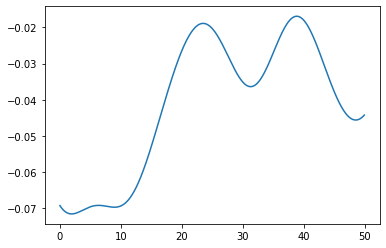

In [10]:
import matplotlib.pyplot as plt
plt.plot(alphas_rest, rest_cond_mu)

In [20]:
log_RMSE_improvements

[-0.018550664939062544,
 0.02692823823428281,
 0.054546916027363945,
 -0.06275970582060642,
 0.0598952799254322,
 -0.03870761302542225,
 0.027711550899556237,
 -0.04945887848461883]

In [21]:
################################ Calculate the RMSE for the test set using this alpha and k combo #########################
ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha=10.82, k_size=best_k, params="rnd")
pred_test = nn_cost_relu([ww, bb, V, bk], X_test)
pred_train = nn_cost_relu([ww, bb, V, bk], X_train)
RMSE_test = np.sqrt(np.mean((y_test[:,None]-pred_test[:,None])**2))
RMSE_train = np.sqrt(np.mean((y_train[:,None]-pred_train[:,None])**2))
print(f'For K={best_k} the RMSE on the test set is: {RMSE_test}. (Note: RMSE_train={RMSE_train})')

For K=19 the RMSE on the test set is: 0.25250715047972916. (Note: RMSE_train=0.05927932079017135)


In [23]:
def train_nn_reg(alpha=30, k_size=20, fitting="alpha"):
    """Fit a random init neural network with regularisation alpha and a hidden layer of size K.
    Return the RMSE on the validation set for this fitted nn"""
    #ww, bb, V, bk = fit_nn_gradopt(X_train, y_train, alpha, k_size, params="rnd") # need rnd init as don´t know K
    # Don´t want to fit K and then alpha on same validation data as sure to overfit.
    # Split validation but keep order to avoid shuffling.
    if fitting=="K":
        print("yess")
        pred_val = nn_cost_relu([ww, bb, V, bk], np.array_split(X_val,2)[0])
        RMSE_val = np.sqrt(np.mean((np.array_split(y_val,2)[0][:,None]-pred_val[:,None])**2))
    else:
        print("Noo")
        pred_val = nn_cost_relu([ww, bb, V, bk], np.array_split(X_val,2)[1])
        RMSE_val = np.sqrt(np.mean((np.array_split(y_val,2)[1][:,None]-pred_val[:,None])**2))
    return RMSE_val

train_nn_reg(alpha=new_alpha, k_size=best_k, fitting="K")

yess


0.19302056105248253

In [26]:
np.array_split(X_val,2)[0]-np.array_split(X_val,2)[1]

ValueError: operands could not be broadcast together with shapes (2893,373) (2892,373) 